## Clasificación de los dígitos de Mnist en forma de set de puntos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from fspool import FSPool
from model import FSEncoder
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
from time import sleep
from tqdm import tqdm

In [6]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 100
net = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [7]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [11]:
 net = net.cuda()

In [12]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x.cuda(), sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

  0%|          | 0/1875 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 99: 100%|██████████| 1875/1875 [00:35<00:00, 52.35batch/s, acc=93.8, loss=0.0801]


In [117]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x.cuda(), sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1:   0%|                                                                                  | 0/312 [00:02<?, ?batch/s]


AssertionError: Torch not compiled with CUDA enabled

In [18]:
#torch.save(net.state_dict(),'model.pth')

In [8]:
model = torch.load('model.pth' ,map_location=torch.device('cpu'))
miNet = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [9]:
miNet.load_state_dict(torch.load('model.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
miNet = miNet
miNet.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 0: 100%|██████████████████████████████████████████████████| 312/312 [07:46<00:00,  1.50s/batch, acc=81.2, loss=0.695]


In [11]:
miNet

FSEncoderClasification(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (pool): FSPool()
)

## Visualización de los filtros

In [12]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

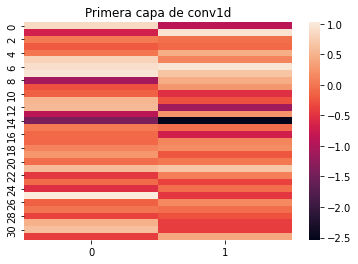

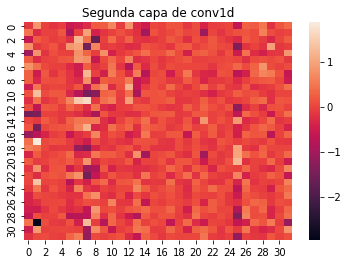

In [13]:
filters= miNet.conv[0].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de conv1d")
pyplot.show()
filters= miNet.conv[2].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de conv1d")
pyplot.show()

torch.Size([32, 21])


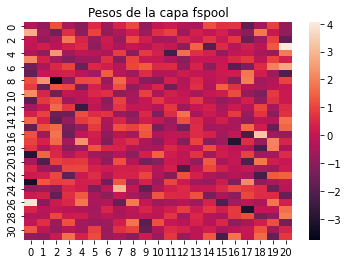

In [14]:
filters= miNet.pool.weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la capa fspool")
pyplot.show()

torch.Size([32, 32])


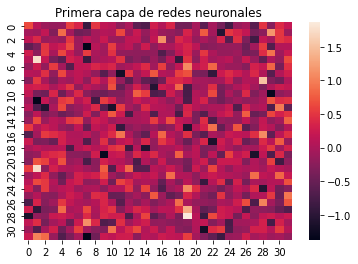

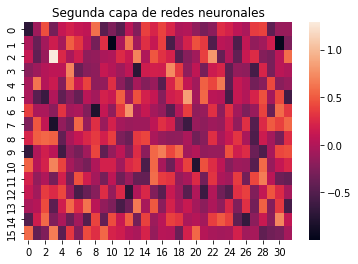

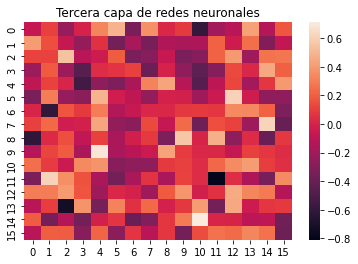

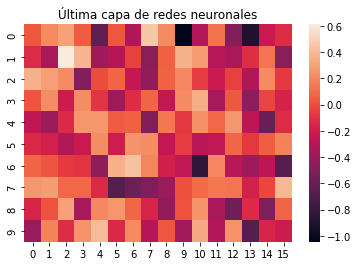

In [15]:
filters= miNet.lin[0].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de redes neuronales")
pyplot.show()
filters= miNet.lin[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[0].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Tercera capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Última capa de redes neuronales")
pyplot.show()

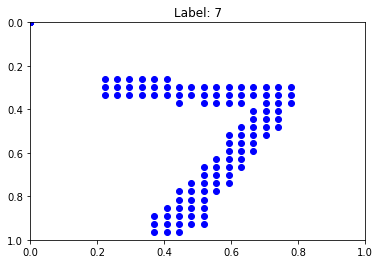

torch.Tensor

In [16]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[0]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)


In [17]:
with torch.no_grad():
    pred = miNet(sample,mask_sample)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

We obtained 7, and the expected is: 7


In [100]:
#Creación del modelo pre-fspooling
class Model1(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        #self.pool = FSPool(dim, 20, relaxed=False)

    def forward(self, x, mask=None):
        x = self.conv(x)
        #x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x
#Creación del modelo post-fspooling

In [101]:
#Creación del modelo pre-fspooling
class Model2(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        self.pool = FSPool(dim, 20, relaxed=True)

    def forward(self, x, mask=None):
        #print(x)
        x = self.conv(x)
        x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x,perm
#Creación del modelo post-fspooling

In [97]:
pre_fspool = miNet.conv
pre_fspool

Sequential(
  (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)

In [99]:
post_fspool = miNet.pool
post_fspool

Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=32, out_features=16, bias=True)
)

In [23]:
from fspool import FSPool

In [24]:
fs = FSPool(32,20,False)

## Visualización de los puntos críticos

torch.Size([1, 32, 342])
tensor([[[-0.1630, -0.3864, -0.1844,  ...,  0.3873,  0.3873,  0.3873],
         [-0.1613, -0.1203, -0.1924,  ...,  0.0027,  0.0027,  0.0027],
         [ 0.4287,  0.2928,  0.5120,  ...,  0.0153,  0.0153,  0.0153],
         ...,
         [-0.5543, -0.2452, -0.6103,  ...,  0.0091,  0.0091,  0.0091],
         [ 0.1311, -0.1397,  0.1609,  ...,  0.0084,  0.0084,  0.0084],
         [ 0.4700,  0.3670,  0.4817,  ..., -0.0276, -0.0276, -0.0276]]])


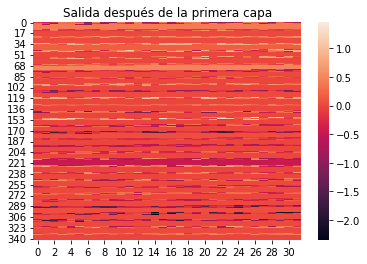

El tamaño de la mascara. torch.Size([1, 32])
torch.Size([1, 32])
[  2.787952     7.970227     0.01495205   8.175733    -0.8901609
  13.591594    -1.6625088   12.338576     3.4726858    0.5511198
   3.6657524    1.4560413    2.070311     1.0076226   -0.09428906
  -3.025549     1.8188453   -6.5057235    4.1939015    3.2683716
 -10.603926    -2.9320307    2.0522416    2.919127     8.314371
   1.6083158  -11.676671    -6.763046     3.011639    -0.9260013
   3.7429368   -3.171469  ]


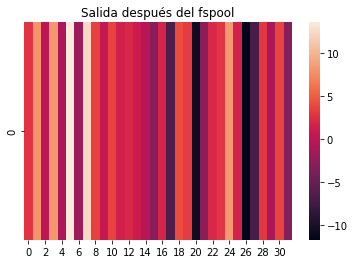

torch.Size([1, 32, 342])
ESTE ES EL UNPOOL
tensor([[[-3.2623e+00, -1.4570e+00, -3.1232e+00,  ...,  6.8405e-02,
           6.8405e-02,  6.8405e-02],
         [ 4.6637e+00,  4.3470e+00,  1.3506e+00,  ..., -1.0283e+00,
          -1.0283e+00, -1.0283e+00],
         [ 7.5368e-04,  1.7698e-02, -8.1380e-03,  ..., -8.4860e-04,
          -8.4860e-04, -8.4860e-04],
         ...,
         [-1.3531e-02,  5.5646e-01, -1.4792e-01,  ..., -1.7379e-02,
          -1.7379e-02, -1.7379e-02],
         [-8.1590e-01,  1.2614e+00, -1.1030e+00,  ..., -3.0908e-02,
          -3.0908e-02, -3.0908e-02],
         [ 2.6507e+00,  1.8692e-02,  2.7793e+00,  ...,  1.5678e-01,
           1.5678e-01,  1.5678e-01]]])


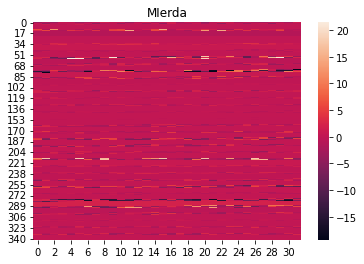

torch.Size([1, 16])


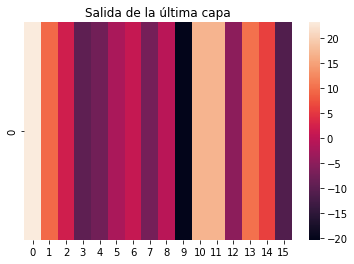

In [61]:
model1 = Model1(set_channels,latent_dim,hidden_dim)
model2 = Model2(set_channels,latent_dim,hidden_dim)
model3 = Model3(set_channels,latent_dim,hidden_dim)
model1.conv = pre_fspool
model2.conv = pre_fspool
model2.pool = post_fspool
model3.conv = pre_fspool
model3.pool = post_fspool
model3.lin = miNet.lin
#print(miNet.conv[0].weight) 
#print(model1.conv[0].weight)
with torch.no_grad():
    
    pred = model1(sample,mask_sample)
    print(pred.shape)
    print(pred)
    nfeatures_pred = pred.detach()
    data = pred.squeeze(0).detach().view(342,32).numpy()
    datakk = data
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después de la primera capa")
    pyplot.show()
    
    pred,perm = model2(sample,mask_sample)
    print("El tamaño de la mascara. {}".format(pred.shape))
    print(pred.shape)
    mapa_de_fspool = pred
    fspool_salida = pred.squeeze(0).detach().numpy()
    print(fspool_salida)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del fspool")
    pyplot.show()
    #print(pred)
    kk,maskara = model2.pool.forward_transpose(pred,perm)
    nfeatures = kk
    print(kk.shape)
    print("ESTE ES EL UNPOOL")
    data = kk.squeeze(0).detach().view(342,32).numpy()
    dataInutil = kk.squeeze(0).detach().numpy()
    print(kk)
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("MIerda")
    pyplot.show()
    
    
    pred = model3(sample,mask_sample)
    print(pred.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida de la última capa")
    pyplot.show()
    

La problematica aqui es que con la operación del fspool, lo que se hace es coger y aplicarle al tensor de entrada de [1,32,342] unos pesos (de los cuales supuestamente salen de hacer una interpolación) y una vez que se realiza dicho producto, se suma la dimensión 2.
A la hora de hacer el unpooling, no se hace del todo debido a que creo que el código esta mal o algo, ya que lo que hace es coger el tensor fspool, y aplicarle nuevamente el vector de pesos(?), cosa que creo que esta mal y que lo mas conveniente sería aplicarle la inversa de dichos pesos 

In [92]:
npoints = sample.squeeze(0).squeeze(0).numpy()
critical = np.zeros(342)
nfeatures.shape
nfeatures_prev = nfeatures_pred.squeeze(0)
mapa_de_caracteristicas = nfeatures_pred
mapakk = mapa_de_caracteristicas[:,5,:].unsqueeze(0)
#print(mapakk)
mapakk = mapakk.expand_as(mapa_de_caracteristicas)
#print(mapakk.shape)
#print(mapakk[:,23,:])
prediccionMagica, permMagica = model2.pool.forward(mapakk)
print(prediccionMagica)
prueba = prediccionMagica.squeeze(0).detach().numpy()
for f in range(32):
    if fspool_salida[f] == prueba[f]:
        print("EUREKAAAA, en la posicion: {}".format(f))
print("Esta es la salida de la primera convolución")
print(mapa_de_caracteristicas)
print("Y su respectivo tamaño: ",mapa_de_caracteristicas.shape)
print('------------------')
print("Esta es la salida del fspool")
print(mapa_de_fspool)
print("Y su respectivo tamaño: ",mapa_de_fspool.shape)
for f in range(32):
    for p in range(342):
        #print(fspool_salida[f])
        #print(nfeatures_prev[f,p].item())
        if nfeatures_prev[f,p].item() == fspool_salida[f]:
            critical[p] += 1
print(critical)
print("+++++++++++++++++")
print(nfeatures_prev.shape)

tensor([[ -4.9319,   6.3109,  -8.1291,   0.1140,   1.5236,  13.5916, -12.7084,
         -10.5011,   7.7661,  -2.4096,  11.6034,   2.2932,   9.0698,  -0.7214,
           1.4848,   8.9332,  11.3216,  21.9259,   1.5999,  -2.4337, -19.8809,
          -9.4474,   8.2324,  -2.4330, -22.0733,  -5.9431,  19.1972,   0.0951,
           1.4129,   4.6044,   2.0917, -13.4761]], grad_fn=<SumBackward1>)
EUREKAAAA, en la posicion: 5
Esta es la salida de la primera convolución
tensor([[[-0.1630, -0.3864, -0.1844,  ...,  0.3873,  0.3873,  0.3873],
         [-0.1613, -0.1203, -0.1924,  ...,  0.0027,  0.0027,  0.0027],
         [ 0.4287,  0.2928,  0.5120,  ...,  0.0153,  0.0153,  0.0153],
         ...,
         [-0.5543, -0.2452, -0.6103,  ...,  0.0091,  0.0091,  0.0091],
         [ 0.1311, -0.1397,  0.1609,  ...,  0.0084,  0.0084,  0.0084],
         [ 0.4700,  0.3670,  0.4817,  ..., -0.0276, -0.0276, -0.0276]]])
Y su respectivo tamaño:  torch.Size([1, 32, 342])
------------------
Esta es la salida del fsp

In [93]:
miNet.pool.ahmed

tensor([[[-3.0594e-01, -3.3982e-01, -3.7369e-01,  ..., -6.6335e-01,
          -7.6902e-01, -8.7468e-01],
         [ 2.8361e+00,  2.6355e+00,  2.4350e+00,  ..., -7.5848e-01,
          -8.1307e-01, -8.6766e-01],
         [ 5.4405e-02,  1.4541e-03, -5.1497e-02,  ..., -1.4640e+00,
          -1.6242e+00, -1.7843e+00],
         ...,
         [-5.5565e-02, -1.5212e-02,  2.5141e-02,  ..., -1.1142e+00,
          -1.2667e+00, -1.4192e+00],
         [ 1.2541e+00,  1.1753e+00,  1.0965e+00,  ...,  2.7926e-01,
           3.4096e-01,  4.0267e-01],
         [-8.6682e-01, -8.6911e-01, -8.7140e-01,  ...,  4.8648e-01,
           6.3136e-01,  7.7624e-01]]], grad_fn=<AddBackward0>)

In [56]:
with torch.no_grad():
    pool = FSPool(2, 1,True)
    x = torch.arange(0, 2*3*4).view(3, 2, 4).float()
    print('x', x)
    y, perm = pool(x)
    print('perm')
    print(perm)
    print('result')
    print(y.sum())
    z,m = pool.forward_transpose(y,perm)
    print(z)
    tensorFspool = x[0]
    print(tensorFspool)
    print(pool.forward(tensorFspool))

x tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.]],

        [[ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.]]])
perm
tensor([[[8.9020e-05, 1.3212e-02, 2.6536e-01, 7.2133e-01],
         [1.0442e-02, 2.0973e-01, 5.7010e-01, 2.0973e-01],
         [2.0973e-01, 5.7010e-01, 2.0973e-01, 1.0442e-02],
         [7.2133e-01, 2.6536e-01, 1.3212e-02, 8.9020e-05]],

        [[8.9020e-05, 1.3212e-02, 2.6536e-01, 7.2133e-01],
         [1.0442e-02, 2.0973e-01, 5.7010e-01, 2.0973e-01],
         [2.0973e-01, 5.7010e-01, 2.0973e-01, 1.0442e-02],
         [7.2133e-01, 2.6536e-01, 1.3212e-02, 8.9020e-05]],

        [[8.9020e-05, 1.3212e-02, 2.6536e-01, 7.2133e-01],
         [1.0442e-02, 2.0973e-01, 5.7010e-01, 2.0973e-01],
         [2.0973e-01, 5.7010e-01, 2.0973e-01, 1.0442e-02],
         [7.2133e-01, 2.6536e-01, 1.3212e-02, 8.9020e-05]],

        [[8.9020e-05, 1.3212e-02, 2.6536e-01, 7.2133e-01],
         [1.0442e-02, 2.0973

AssertionError: incorrect number of input channels in weight